# Preprocessing the Dataset
This notebook contains the code used to import the original dataset, as well as selecting the AIS reports related to fishing activities. This selection is then analyzed, filtered, formatted and finally exported to .csv files for later use.

The first step is to import the necessary libraries, as well as defining a `getValues` utility fonction which essentialy wraps Pandas' method `DataFrame.value_counts` but let us order the resulting dictionnary by *key* or by *value*.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as md
from shapely.geometry import box
from scipy.spatial import cKDTree
from utils import getValues, DATASETS_DIRECTORY_PATH

Next, we use Pandas' function `read_csv` to import the beforehand downloaded original .csv files, and we then use the `.head` method to take a look at how the dataset is built.

In [2]:
dynamic = pd.read_csv(f'{DATASETS_DIRECTORY_PATH}Originals/nari_dynamic.csv')
static = pd.read_csv(f'{DATASETS_DIRECTORY_PATH}Originals/nari_static.csv')

C:\Users\baudo\AppData\Local\Temp\ipykernel_1392\3381703879.py:2: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  static = pd.read_csv(f'{DATASETS_DIRECTORY_PATH}Originals/nari_static.csv')


In [3]:
dynamic.head()

,sourcemmsi,navigationalstatus,rateofturn,speedoverground,courseoverground,trueheading,lon,lat,t
0,245257000,0.0,0.0,0.1,13.1,36,-4.465718,48.382490,1443650402
1,227705102,15.0,-127.0,0.0,262.7,511,-4.496571,48.382420,1443650403
2,228131600,15.0,-127.0,8.5,263.7,511,-4.644325,48.092247,1443650404
3,228051000,0.0,-127.0,0.0,295.0,511,-4.485108,48.381320,1443650405
4,227574020,15.0,-127.0,0.1,248.6,511,-4.495441,48.383660,1443650406


In [4]:
static.head()

,sourcemmsi,imonumber,callsign,shipname,shiptype,tobow,tostern,tostarboard,toport,eta,draught,destination,mothershipmmsi,t
0,304091000,9509255.0,V2GU5,HC JETTE-MARIT,70.0,130.0,30.0,18.0,6.0,04-09 20:00,10.1,BREST,NaN,1443650423
1,228037600,0.0,FIHX,AEROUANT BREIZH,30.0,6.0,9.0,5.0,2.0,00-00 24:60,0.0,,NaN,1443650457
2,228064900,8304816.0,FITO,VN SAPEUR,51.0,21.0,54.0,10.0,6.0,29-09 12:00,5.9,RADE DE BREST,NaN,1443650471
3,227705102,262144.0,FGD5860,BINDY,60.0,9.0,26.0,5.0,4.0,00-00 24:60,0.0,,NaN,1443650474
4,227415000,0.0,FHAF,F/V JEREMI SIMON,90.0,11.0,9.0,3.0,3.0,00-00 24:60,0.0,,NaN,1443650479


This next piece of code handles the selection of data related to declared fishing vessels (i.e. those who emitted at least one static message with a *shiptype* of *30*), as well as some basic formatting (*timestamp* and *geometry* handling, deletion of redundant columns, deletion of duplicate rows, and basic index reset).

In [5]:
static = static.loc[static.shiptype == 30]
static['timestamp'] = static.t.astype('datetime64[s]')
static = static.drop('t', axis='columns')
static = static.reset_index(drop=True)

mmsi_fishing_vessels = getValues(static.sourcemmsi)
temp = dynamic.loc[dynamic.sourcemmsi.isin(mmsi_fishing_vessels)]
temp = gpd.GeoDataFrame(temp, geometry=gpd.points_from_xy(temp.lon, temp.lat), crs='EPSG:4326')
temp['timestamp'] = temp.t.astype('datetime64[s]')
temp = temp.drop(['lon', 'lat', 't'], axis='columns')
temp = temp.drop_duplicates() #some reports are duplicated within the original dataset
temp = temp.sort_values('timestamp')
dynamic = temp.reset_index(drop=True)

The following lines conduct a basic analysis of the dataset.

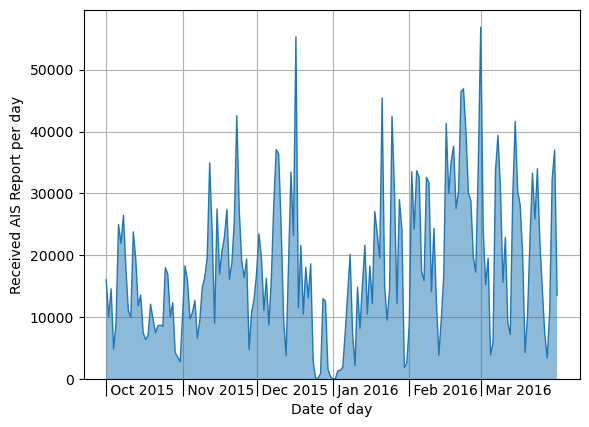

In [6]:
temp = dynamic.timestamp.round('D')
temp = getValues(temp, orderby='key', descending=False)
fig, ax = plt.subplots()
ax.plot(temp.keys(), temp.values(), lw=1, aa=True, zorder=3)
ax.fill_between(temp.keys(), temp.values(), alpha=0.5, zorder=2)
ax.set_ylabel('Received AIS Report per day')
ax.set_xlabel('Date of day')
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xticks(ax.get_xticks()[:-1])
ax.xaxis.set_major_formatter(md.DateFormatter(' %b %Y'))
ax.tick_params(axis='x', length=12, pad=-9)
for label in ax.get_xticklabels():
    label.set(horizontalalignment='left')
ax.grid()

In [7]:
temp = pd.DataFrame()
temp['mmsi'] = getValues(dynamic.sourcemmsi).keys()

def findTimespan(mmsi):
    first = dynamic.loc[dynamic.sourcemmsi == mmsi].iloc[:1].timestamp.iloc[0]
    last = dynamic.loc[dynamic.sourcemmsi == mmsi].iloc[-1:].timestamp.iloc[0]
    return (last - first).round('D').days

temp['timespan'] = temp.applymap(findTimespan)
temp['reports'] = temp.mmsi.apply(lambda mmsi: len(dynamic.loc[dynamic.sourcemmsi == mmsi]))
temp = temp.sort_values('reports',ascending=False)
temp = temp.reset_index(drop=True)

X, Y = temp.timespan, temp.reports

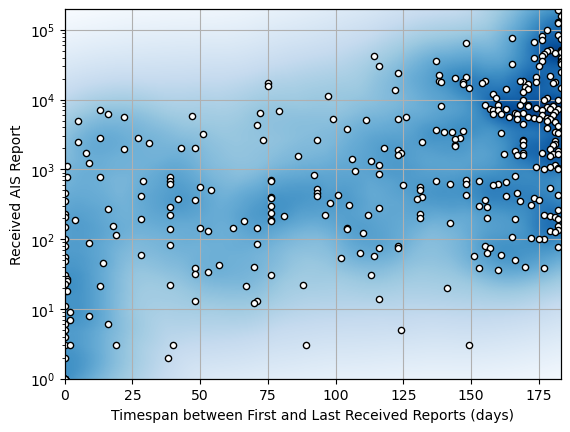

In [8]:
fig, ax2 = plt.subplots()
ax1 = ax2.twinx()

ax1.scatter(X, Y, s=20, c='w', edgecolors='k', zorder=2)
ax1.set_yscale('log')
ax1.set_ylim(Y.min(), Y.max())
ax1.grid(which='major', axis='y', zorder=0)
ax1.set_ylabel('Received AIS Report')
ax1.yaxis.set_label_position('left')
ax1.yaxis.tick_left()

def data_coord2view_coord(p, resolution):
    dp = np.max(p) - np.min(p)
    dv = (p - np.min(p)) / dp * resolution
    return dv

resolution = 100
xs = X
ys = np.log10(Y)
extent = [np.min(xs), np.max(xs), np.max(ys), np.min(ys)]
xv = data_coord2view_coord(xs, resolution)
yv = data_coord2view_coord(ys, resolution)

def heatmap(xv, yv, resolution, neighbours):
    tree = cKDTree(np.array([xv, yv]).T)
    grid = np.mgrid[0:resolution, 0:resolution].T.reshape(resolution**2, 2)
    dists = tree.query(grid, neighbours)
    inv_sum_dists = 1. / dists[0].sum(1)
    im = inv_sum_dists.reshape(resolution, resolution)
    return im

neighbours = 16
im = heatmap(xv, yv, resolution, neighbours)
ax2.imshow(im, aspect='auto', extent=extent, norm='log',
           cmap='Blues', interpolation='gaussian')
ax2.set_xlim(extent[0], extent[1])
ax2.set_ylim(extent[2], extent[3])

ax2.invert_yaxis()
ax2.set_yticks([])
ax2.set_xlabel('Timespan between First and Last Received Reports (days)')
ax2.grid(which='major', axis='x')
fig.savefig('Figures/nb-vs-ts.png', dpi=600)

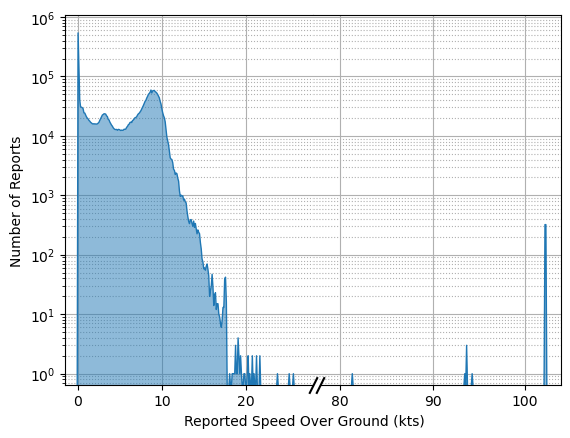

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.subplots_adjust(wspace=0)

baseline = 0.6
X = dynamic.speedoverground.value_counts(dropna=False)
index = X.index
before = lambda x: round(x - 0.1, 1)
after = lambda x: round(x + 0.1, 1)
for x in index:
    if before(x) not in index:
        X[before(x)] = baseline
    if after(x) not in index:
        X[after(x)] = baseline
X = X.sort_index()
X, Y = X.index, X.values

ax1.plot(X, Y, lw=1, aa=True, zorder=3)
ax2.plot(X, Y, lw=1, aa=True, zorder=3)

ax1.fill_between(X, Y, baseline, alpha=0.5, zorder=2)
ax2.fill_between(X, Y, baseline, alpha=0.5, zorder=2)
ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_xlim(X.min() - 1.5, 28)
ax2.set_xlim(77, X.max() + 1.5)
ymax = ax1.get_ylim()[1]
offset = 0.05
ax1.set_ylim(baseline + offset, ymax)
ax2.set_ylim(baseline + offset, ymax)

ax1.grid()
ax1.grid(which='minor', ls=':', axis='y')
ax2.grid()
ax2.grid(which='minor', ls=':', axis='y')
ax1.set_ylabel('Number of Reports')
fig.supxlabel('Reported Speed Over Ground (kts)', size='medium', y=0.02)

ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax2.yaxis.set_ticks_position('none')
ax2.yaxis.set_ticklabels('')

d = 2
kwargs1 = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1.5,
              zorder=4, clip_on=False)
kwargs2 = dict(marker=[(0, 0), (1, 0)], markersize=12,
              linestyle="none", color='w', mec='w', mew=3,
              zorder=4, clip_on=False)
ax2.plot(0, 0, transform=ax2.transAxes, **kwargs2)
ax2.plot(0, 0, transform=ax2.transAxes, **kwargs1)
ax2.plot(0.03, 0, transform=ax2.transAxes, **kwargs1)

In [10]:
countries = gpd.read_file('Datasets/ref-countries-2020-01m.geojson/CNTR_RG_01M_2020_4326.geojson')

C:\Users\baudo\AppData\Local\Temp\ipykernel_1392\1247556448.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([dec2deg(coord, 'x') for coord in ax.get_xticks()])
C:\Users\baudo\AppData\Local\Temp\ipykernel_1392\1247556448.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([dec2deg(coord, 'y') for coord in ax.get_yticks()])


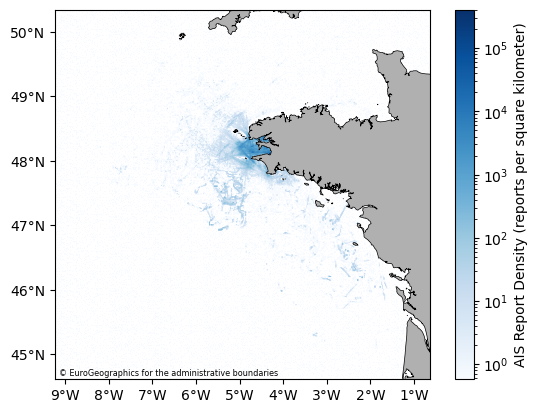

In [11]:
west, south, east, north = dynamic.total_bounds
padding = 0.08
west -= (east - west)*padding
east += (east - west)*padding
south -= (north - south)*padding
north += (north - south)*padding
UK = countries[countries.id=='UK']
FR = countries[countries.id=='FR']
fig, ax = plt.subplots()
cr = '\u00A9 EuroGeographics for the administrative boundaries'
ax.text(0.01, 0.01, cr, transform=ax.transAxes, size='xx-small')
FR.plot(ax=ax, zorder=2, color='#b0b0b0')
UK.plot(ax=ax, zorder=2, color='#b0b0b0')
FR.boundary.plot(ax=ax, zorder=3, lw=0.5, aa=True, color='0')
UK.boundary.plot(ax=ax, zorder=3, lw=0.5, aa=True, color='0')

bins = 500
xedges = np.linspace(west, east, bins + 1)
yedges = np.linspace(south, north, bins + 1)
X, Y = dynamic.geometry.x, dynamic.geometry.y
heatmap, xedges, yedges = np.histogram2d(X, Y, bins=(xedges, yedges))
extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]

xlenght = (east - west) / bins * 60 * 1.852
ylenght = (north - south) / bins * 60 * 1.852
deformation = np.cos(np.deg2rad(np.vstack([np.linspace(south, north, bins)] * bins)))
binarea = xlenght * ylenght * deformation

img = ax.imshow((heatmap / binarea).T, extent=extent,
                aspect='equal', norm='log', cmap='Blues')
cbar = fig.colorbar(img)
cbar.ax.set_ylabel('AIS Report Density (reports per square kilometer)')
ax.set_xlim(west, east)
ax.set_ylim(south, north)

def dec2deg(coord, axis=None):
    direction = ''
    if axis == 'x':
        if coord > 0:
            direction = 'E'
        elif coord < 0:
            direction = 'W'
    elif axis == 'y':
        if coord > 0:
            direction = 'N'
        elif coord < 0:
            direction = 'S'
    coord = abs(coord)
    degs = np.floor(coord).astype(int)
    return f'{degs}\u00B0{direction}'

ax.set_xticklabels([dec2deg(coord, 'x') for coord in ax.get_xticks()])
ax.set_yticklabels([dec2deg(coord, 'y') for coord in ax.get_yticks()])

yxratio = 1/np.cos(np.deg2rad((south+north)/2.))
ax.set_aspect(yxratio)

Finally, we can export the resulting dataset as two separate .csv files.

In [12]:
static.to_csv(f'{DATASETS_DIRECTORY_PATH}static.csv', index=False)
dynamic.to_csv(f'{DATASETS_DIRECTORY_PATH}dynamic.csv', index=False)